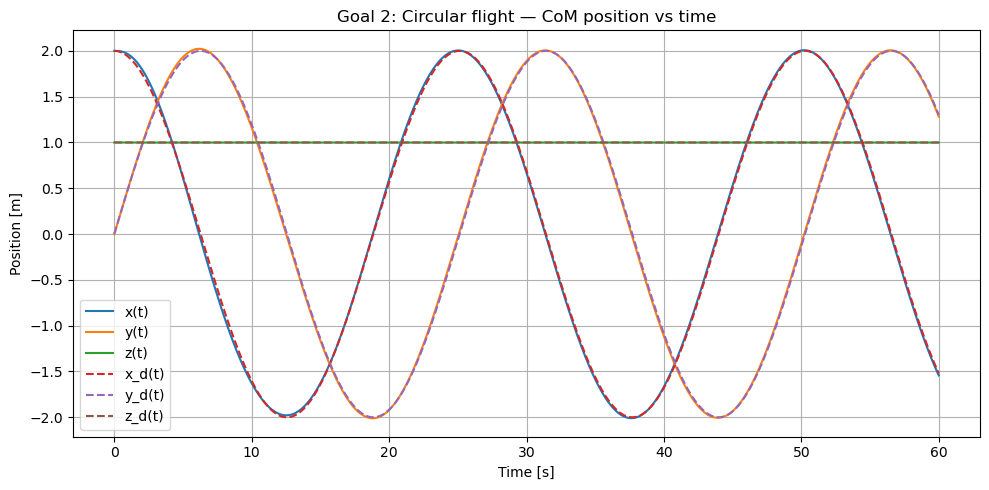

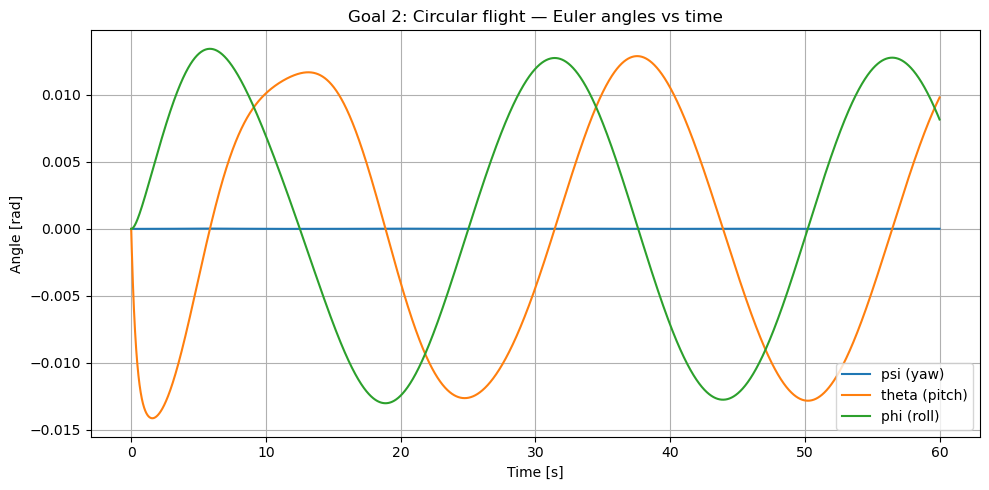

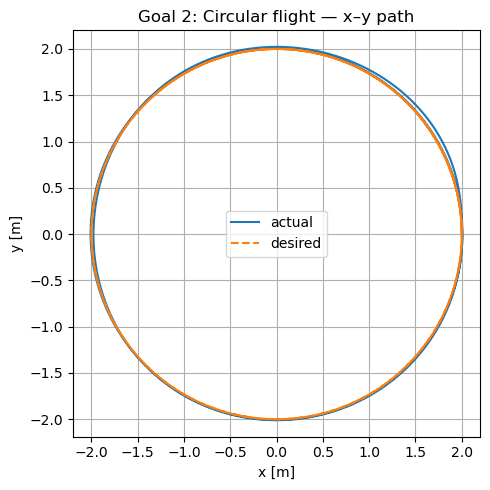

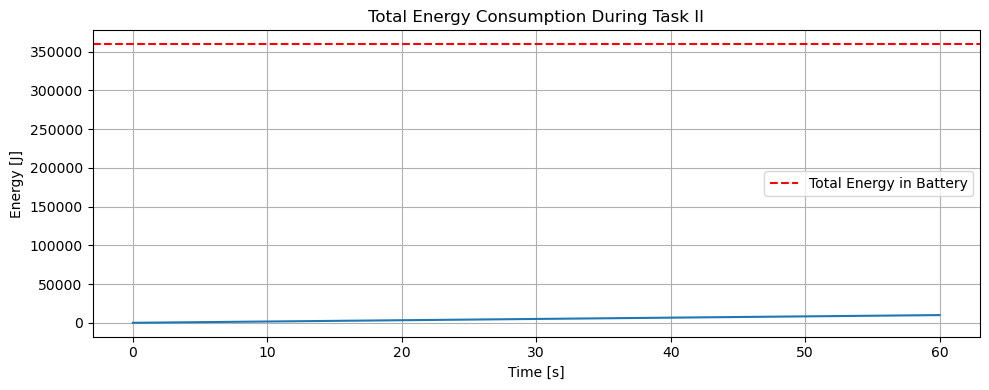

Battery consumed (mAh): 124.52276601909391
Percent of 1300 mAh battery used: 2.7671725782020866 %


In [5]:
import numpy as np
import matplotlib.pyplot as plt

kf = (7.21197687521095)*10**-5 /(4*np.pi**2)    # thrust coefficient
kt = (4.89265212548263)*10**-6  /(4*np.pi**2)  # yaw torque coefficient
l  = 0.13    # arm length [m]
m  = 0.3469     # mass [kg]
g  = 9.81    # gravity [m/s^2]

Ixx = 3.468 * 10**-4
Iyy = 3.468 * 10**-4
Izz = 6.935 * 10**-4


R = 2.0         # radius [m]
v = 0.5         # speed [m/s]
omega = v / R   # angular rate [rad/s]

def desired_trajectory(t):

    x_d = R * np.cos(omega * t)
    y_d = R * np.sin(omega * t)
    z_d = 1.0

    vx_d = -R * omega * np.sin(omega * t)
    vy_d =  R * omega * np.cos(omega * t)
    vz_d = 0.0

    ax_d = -R * (omega**2) * np.cos(omega * t)
    ay_d = -R * (omega**2) * np.sin(omega * t)
    az_d = 0.0

    psi_d = 0.0

    pos_d = np.array([x_d, y_d, z_d])
    vel_d = np.array([vx_d, vy_d, vz_d])
    acc_d = np.array([ax_d, ay_d, az_d])

    return pos_d, vel_d, acc_d, psi_d




A = np.array([
    [kf,      kf,      kf,      kf     ],          # T
    [0.0,    -l*kf,   0.0,     l*kf    ],          # tau_phi
    [-l*kf,   0.0,    l*kf,    0.0     ],          # tau_theta
    [kt,     -kt,     kt,     -kt      ]           # tau_psi
])

A_inv = np.linalg.inv(A)

Kp_pos = np.array([0.4, 0.4, 1.0])
Kd_pos = np.array([0.3, 0.3, 0.7])


Kp_att = np.array([1.2, 1.2, 0.8])   # roll, pitch, yaw
Kd_att = np.array([0.4, 0.4, 0.3])



def control_inputs(t, state):

    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = state

    pos   = np.array([x, y, z])
    vel   = np.array([vx, vy, vz])
    pos_d, vel_d, acc_d, psi_d = desired_trajectory(t)

    e_pos = pos_d - pos
    e_vel = vel_d - vel

    a_des = acc_d + Kp_pos * e_pos + Kd_pos * e_vel
    ax_des, ay_des, az_des = a_des

    T_des = m * (g + az_des)


    T_des = np.clip(T_des, 0.0, 2.0 * m * g)

    theta_des = ax_des / g
    phi_des   = -ay_des / g


    phi_des   = np.clip(phi_des,   -np.deg2rad(20), np.deg2rad(20))
    theta_des = np.clip(theta_des, -np.deg2rad(20), np.deg2rad(20))


    psi_des = psi_d

    # ===== Inner loop: attitude =====
    e_phi   = phi_des   - phi
    e_theta = theta_des - theta
    e_psi   = psi_des   - psi

    e_p = -wx
    e_q = -wy
    e_r = -wz

    tau_phi   = Kp_att[0] * e_phi   + Kd_att[0] * e_p
    tau_theta = Kp_att[1] * e_theta + Kd_att[1] * e_q
    tau_psi   = Kp_att[2] * e_psi   + Kd_att[2] * e_r


    tau_limit_phi = 0.06
    tau_limit_theta = 0.06
    tau_limit_psi = 0.03
    tau_phi   = np.clip(tau_phi, -tau_limit_phi, tau_limit_phi)
    tau_theta = np.clip(tau_theta, -tau_limit_theta, tau_limit_theta)
    tau_psi   = np.clip(tau_psi, -tau_limit_psi, tau_limit_psi)



    b = np.array([T_des, tau_phi, tau_theta, tau_psi])
    Omega_sq = A_inv @ b


    Omega_sq = np.clip(Omega_sq, 0.0, (2 * m * g / (4 * kf))**2)
    gammas = np.sqrt(Omega_sq)

    return gammas



def quad_dynamics(t, s):
    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = s

    g1, g2, g3, g4 = control_inputs(t, s)
    T = kf * (g1**2 + g2**2 + g3**2 + g4**2)

    # Short-hands
    sin_phi   = np.sin(phi)
    cos_phi   = np.cos(phi)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    sin_psi   = np.sin(psi)
    cos_psi   = np.cos(psi)

    # Avoid division by zero in tan / sec
    if abs(cos_theta) < 1e-6:
        cos_theta = 1e-6
    tan_theta = np.tan(theta)

    # Kinematics
    x_dot = vx
    y_dot = vy
    z_dot = vz

    # Euler angle kinematics (ZYX: yaw ψ, pitch θ, roll φ)
    psi_dot   = (wy * sin_phi + wz * cos_phi) / cos_theta
    theta_dot =  wy * cos_phi - wz * sin_phi
    phi_dot   =  wx + wy * sin_phi * tan_theta + wz * cos_phi * tan_theta

    # Translational dynamics (in inertial frame)
    vx_dot = (T/m)*(cos_phi*cos_psi*sin_theta + sin_phi*sin_psi)
    vy_dot = (T/m)*(cos_phi*sin_psi*sin_theta - cos_psi*sin_phi)
    vz_dot = (T/m)*(cos_phi*cos_theta) - g


    # Torques from rotor speeds (for consistency with your EOM)
    tau_phi   =  l * kf * (g4**2 - g2**2)
    tau_theta =  l * kf * (g3**2 - g1**2)
    tau_psi   =  kt * (g1**2 - g2**2 + g3**2 - g4**2)

    wx_dot = (tau_phi   - (Izz - Iyy) * wy * wz) / Ixx
    wy_dot = (tau_theta - (Ixx - Izz) * wx * wz) / Iyy
    wz_dot = (tau_psi   - (Iyy - Ixx) * wx * wy) / Izz

    return np.array([
        x_dot, y_dot, z_dot,
        vx_dot, vy_dot, vz_dot,
        psi_dot, theta_dot, phi_dot,
        wx_dot, wy_dot, wz_dot
    ])



def rk4_step(f, t, s, dt):
    k1 = f(t,         s)
    k2 = f(t + 0.5*dt, s + 0.5*dt*k1)
    k3 = f(t + 0.5*dt, s + 0.5*dt*k2)
    k4 = f(t + dt,     s + dt*k3)
    return s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)



T_final = 60.0   # [s]
dt      = 0.002
N       = int(T_final / dt) + 1

t_vals  = np.linspace(0.0, T_final, N)
states  = np.zeros((N, 12))


pos0, vel0, acc0, psi0_d = desired_trajectory(0.0)
s0 = np.zeros(12)
s0[0:3] = pos0          # x, y, z
s0[3:6] = vel0          # vx, vy, vz
s0[6]   = psi0_d        # psi
# theta, phi, wx, wy, wz stay 0
states[0, :] = s0



# Time stepping
for k in range(N - 1):
    t = t_vals[k]
    s = states[k, :]
    states[k+1, :] = rk4_step(quad_dynamics, t, s, dt)


x_vals = states[:, 0]
y_vals = states[:, 1]
z_vals = states[:, 2]

psi_vals   = states[:, 6]
theta_vals = states[:, 7]
phi_vals   = states[:, 8]

pos_d_all = np.array([desired_trajectory(t)[0] for t in t_vals])
x_d_vals  = pos_d_all[:, 0]
y_d_vals  = pos_d_all[:, 1]
z_d_vals  = pos_d_all[:, 2]


plt.figure(figsize=(10, 5))
plt.plot(t_vals, x_vals, label='x(t)')
plt.plot(t_vals, y_vals, label='y(t)')
plt.plot(t_vals, z_vals, label='z(t)')
plt.plot(t_vals, x_d_vals, '--', label='x_d(t)')
plt.plot(t_vals, y_d_vals, '--', label='y_d(t)')
plt.plot(t_vals, z_d_vals, '--', label='z_d(t)')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Goal 2: Circular flight — CoM position vs time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(t_vals, psi_vals,   label='psi (yaw)')
plt.plot(t_vals, theta_vals, label='theta (pitch)')
plt.plot(t_vals, phi_vals,   label='phi (roll)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Goal 2: Circular flight — Euler angles vs time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(x_vals, y_vals, label='actual')
plt.plot(x_d_vals, y_d_vals, '--', label='desired')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Goal 2: Circular flight — x–y path')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


gammas_hist = np.zeros((N, 4))


states_h = np.zeros((N, 12))
states_h[0, :] = s0

for k in range(N - 1):
    t = t_vals[k]
    s = states_h[k, :]

    gam = control_inputs(t, s)
    gammas_hist[k, :] = gam

    states_h[k+1, :] = rk4_step(quad_dynamics, t, s, dt)

gammas_hist[-1, :] = control_inputs(t_vals[-1], states_h[-1, :])




P_mech = np.zeros(N)
P_each = np.zeros((N, 4))

for k in range(N):
    g1, g2, g3, g4 = gammas_hist[k]

    P1 = kt * g1**3
    P2 = kt * g2**3
    P3 = kt * g3**3
    P4 = kt * g4**3

    P_each[k] = np.array([P1, P2, P3, P4])
    P_mech[k] = P1 + P2 + P3 + P4




V_bat = 22.2
eta   = 0.95



P_elec = P_mech / eta

CapTotalE = 4500 / 1000 * 3600 * V_bat

count2 = np.zeros_like(P_elec)
for i in range(len(P_elec)):
  if i == 0:
    count2[i] = P_elec[i] * dt
  else:
    count2[i] = count[i-1] + P_elec[i] * dt
plt.figure(figsize=(10, 4))
plt.plot(t_vals, count2)
plt.xlabel("Time [s]")
plt.ylabel("Energy [J]")
plt.axhline(CapTotalE, color='r', linestyle='--', label='Total Energy in Battery')
plt.title("Total Energy Consumption During Task II")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


I_bat = P_elec / V_bat


Coulombs = np.trapz(I_bat, t_vals)


mAh_used = Coulombs * 1000 / 3600
print("Battery consumed (mAh):", mAh_used)

battery_size_mAh = 4500
percent_used = 100 * mAh_used / battery_size_mAh
print("Percent of 1300 mAh battery used:", percent_used, "%")


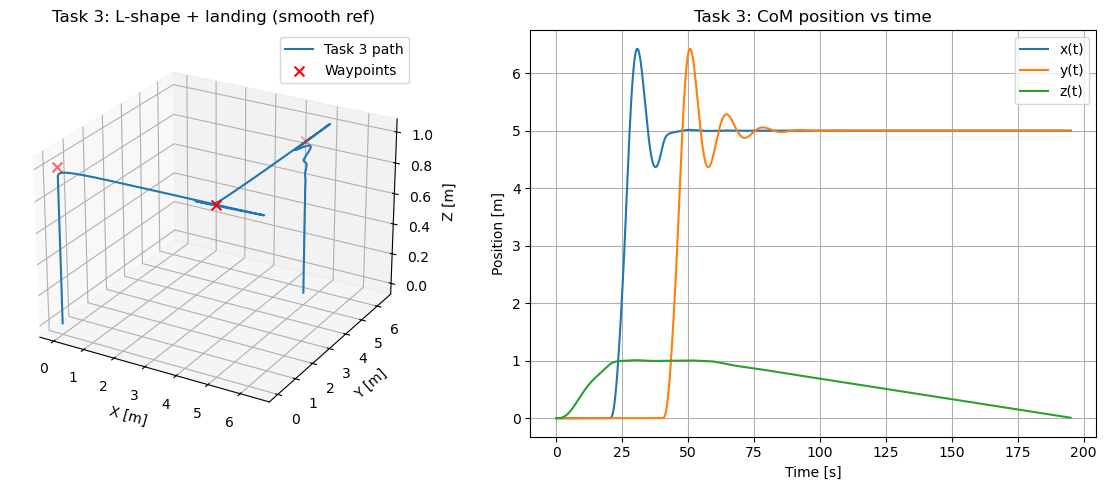

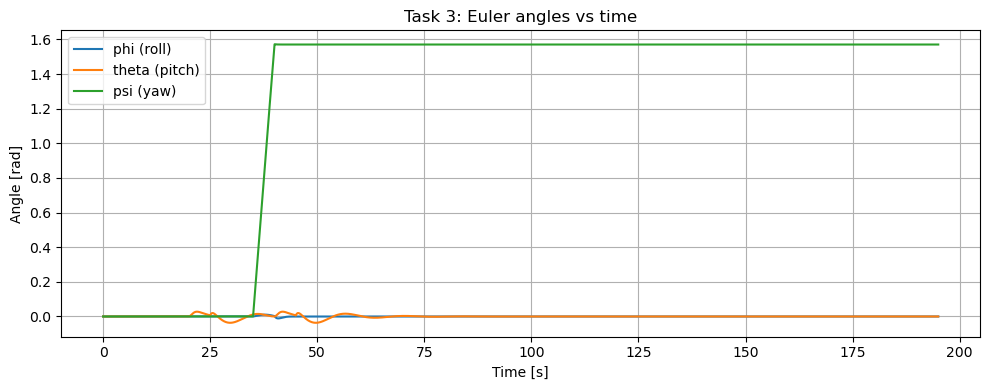

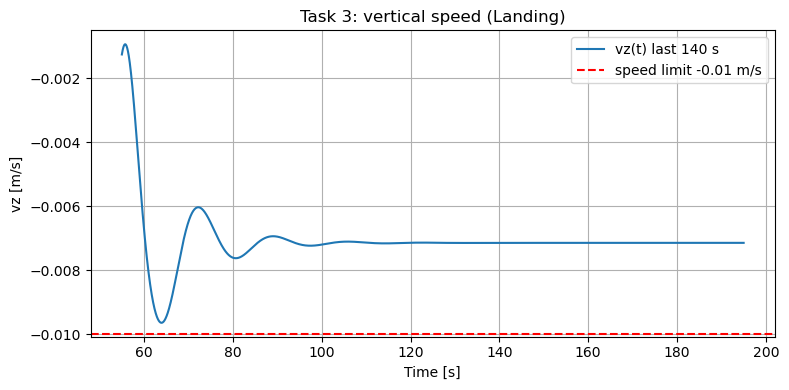

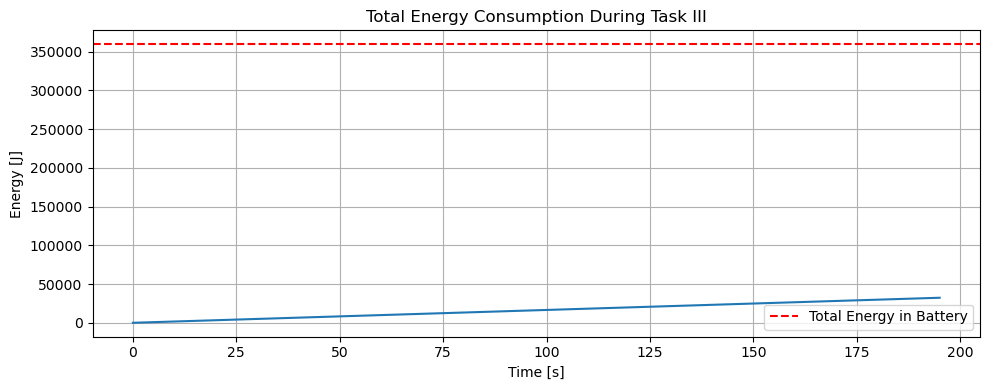

Battery consumed (mAh): 404.6707089479088
Percent of 1300 mAh battery used: 8.99268242106464 %


In [6]:

import matplotlib.pyplot as plt

import numpy as np

import numpy as np

def desired_trajectory_task3(t):

    T1, T2, T3, T4, T5, T6, T7 = 20.0, 5.0, 10.0, 5.0, 5.0, 10.0, 140.0
    b1 = T1
    b2 = b1 + T2
    b3 = b2 + T3
    b4 = b3 + T4
    b5 = b4 + T5
    b6 = b5 + T6
    b7 = b6 + T7


    x0, y0, z0, psi0 = 0.0, 0.0, 0.0, 0.0
    x1, y1, z1       = 0.0, 0.0, 1.0
    x2, y2           = 5.0, 0.0
    x3, y3           = 5.0, 5.0
    psi_final        = 0.5 * np.pi

    x_d = x0; y_d = y0; z_d = z0; psi_d = psi0


    t_decel = 0.5


    if t < b1:
        x_d, y_d = x0, y0
        z_d = np.interp(t, [0.0, b1], [z0, z1])
        psi_d = psi0

    elif t < b2:
        dt_phase = t - b1
        T_phase = b2 - b1
        distance = x2 - x1
        v_const = distance / (T_phase - 0.5 * t_decel)

        if dt_phase < T_phase - t_decel:
            x_d = x1 + v_const * dt_phase
        else:
            dt_dec = dt_phase - (T_phase - t_decel)
            a_dec = v_const / t_decel
            x_d = x2 - 0.5 * a_dec * (t_decel - dt_dec)**2

        y_d = y1
        z_d = z1
        psi_d = psi0

    elif t < b3:
        x_d, y_d, z_d, psi_d = x2, y2, z1, psi0

    elif t < b4:
        dt_phase = t - b3
        T_phase = b4 - b3
        psi_d = np.interp(dt_phase, [0, T_phase], [psi0, psi_final])
        x_d, y_d, z_d = x2, y2, z1

    elif t < b5:
        dt_phase = t - b4
        T_phase = b5 - b4
        distance = y3 - y2
        v_const = distance / (T_phase - 0.5 * t_decel)

        if dt_phase < T_phase - t_decel:
            y_d = y2 + v_const * dt_phase
        else:
            dt_dec = dt_phase - (T_phase - t_decel)
            a_dec = v_const / t_decel
            y_d = y3 - 0.5 * a_dec * (t_decel - dt_dec)**2

        x_d = x2
        z_d = z1
        psi_d = psi_final

    elif t < b6:
        x_d, y_d, z_d, psi_d = x3, y3, z1, psi_final

    else:
        x_d, y_d = x3, y3
        z_d = np.interp(t, [b6, b7], [z1, 0.0])
        psi_d = psi_final

    pos_d = np.array([x_d, y_d, z_d])
    vel_d = np.zeros(3)
    acc_d = np.zeros(3)

    return pos_d, vel_d, acc_d, psi_d







Kp_pos_task3 = np.array([0.2, 0.2, 0.15])
Kd_pos_task3 = np.array([0.15, 0.15, 0.1])


Kp_att_task3 = np.array([0.5, 0.5, 0.3])
Kd_att_task3 = np.array([0.2, 0.2, 0.15])




def control_inputs_task3(t, state):

    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = state


    pos = np.array([x, y, z])
    vel = np.array([vx, vy, vz])

    pos_d, vel_d, acc_d, psi_d = desired_trajectory_task3(t)

    e_pos = pos_d - pos
    e_vel = vel_d - vel


    T1, T2, T3, T4, T5, T6, T7 = 20.0, 5.0, 10.0, 5.0, 5.0, 10.0, 140.0
    b1 = T1
    b2 = b1 + T2
    b3 = b2 + T3
    b4 = b3 + T4
    b5 = b4 + T5
    b6 = b5 + T6
    b7 = b6 + T7

    Kp_pos = np.array([0.2, 0.2, 0.15])
    Kd_pos = np.array([0.3, 0.3, 0.2])


    if b1 <= t < b2 or b4 <= t < b5:
        Kp_pos = np.array([0.35, 0.35, 0.25])
        Kd_pos = np.array([1.2, 1.2, 1])


    a_des = acc_d + Kp_pos * e_pos + Kd_pos * e_vel
    ax_des, ay_des, az_des = a_des


    a_tot = a_des + np.array([0.0, 0.0, g])

    norm_a = np.linalg.norm(a_tot)
    if norm_a < 1e-6:

        a_tot = np.array([0.0, 0.0, g])
        norm_a = g


    b3_des = a_tot / norm_a


    T_des = m * norm_a


    c_psi = np.cos(psi_d)
    s_psi = np.sin(psi_d)
    b1_psi = np.array([c_psi, s_psi, 0.0])


    b2_des = np.cross(b3_des, b1_psi)
    n_b2 = np.linalg.norm(b2_des)
    if n_b2 < 1e-6:

        b1_psi = np.array([1.0, 0.0, 0.0])
        b2_des = np.cross(b3_des, b1_psi)
        n_b2 = np.linalg.norm(b2_des)
        if n_b2 < 1e-6:

            b3_des = np.array([0.0, 0.0, 1.0])
            b2_des = np.array([0.0, 1.0, 0.0])
            T_des = m * g

    b2_des /= n_b2

    b1_des = np.cross(b2_des, b3_des)


    R_des = np.column_stack((b1_des, b2_des, b3_des))


    R20 = np.clip(R_des[2, 0], -1.0, 1.0)
    theta_des = -np.arcsin(R20)
    phi_des   = np.arctan2(R_des[2, 1], R_des[2, 2])

    psi_des = psi_d


    e_phi   = phi_des   - phi
    e_theta = theta_des - theta
    e_psi   = psi_des   - psi


    e_p = -wx
    e_q = -wy

    if  b3 <= t <= b4:
      psi_dot_des = (.5 * np.pi - 0) / (b4-b3)
    else:
      psi_dot_des = 0.0

    e_r = psi_dot_des - wz



    tau_phi   = Kp_att_task3[0] * e_phi   + Kd_att_task3[0] * e_p
    tau_theta = Kp_att_task3[1] * e_theta + Kd_att_task3[1] * e_q
    tau_psi   = Kp_att_task3[2] * e_psi   + Kd_att_task3[2] * e_r


    tau_phi   = np.clip(tau_phi,   -0.3, 0.3)
    tau_theta = np.clip(tau_theta, -0.3, 0.3)
    tau_psi   = np.clip(tau_psi,   -0.2, 0.2)

    T_des = np.clip(T_des, 0.0, 2.0 * m * g)

    b_vec = np.array([T_des, tau_phi, tau_theta, tau_psi])
    Omega_sq = A_inv @ b_vec
    Omega_sq = np.clip(Omega_sq, 0.0, (2 * m * g / (4 * kf))**2)
    gammas = np.sqrt(Omega_sq)

    return gammas



def quad_dynamics_task3(t, s):
    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = s

    g1, g2, g3, g4 = control_inputs_task3(t, s)
    T = kf * (g1**2 + g2**2 + g3**2 + g4**2)

    sin_phi   = np.sin(phi)
    cos_phi   = np.cos(phi)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    sin_psi   = np.sin(psi)
    cos_psi   = np.cos(psi)

    if abs(cos_theta) < 1e-6:
        cos_theta = 1e-6
    tan_theta = np.tan(theta)

    # Kinematics
    x_dot = vx
    y_dot = vy
    z_dot = vz

    psi_dot   = (wy * sin_phi + wz * cos_phi) / cos_theta
    theta_dot =  wy * cos_phi - wz * sin_phi
    phi_dot   =  wx + wy * sin_phi * tan_theta + wz * cos_phi * tan_theta

    # Translational dynamics
    vx_dot = (T/m)*(cos_phi*cos_psi*sin_theta + sin_phi*sin_psi)
    vy_dot = (T/m)*(cos_phi*sin_psi*sin_theta - cos_psi*sin_phi)
    vz_dot = (T/m)*(cos_phi*cos_theta) - g

    # Torques from motor speeds
    tau_phi   =  l * kf * (g4**2 - g2**2)
    tau_theta =  l * kf * (g3**2 - g1**2)
    tau_psi   =  kt * (g1**2 - g2**2 + g3**2 - g4**2)

    wx_dot = (tau_phi   - (Izz - Iyy) * wy * wz) / Ixx
    wy_dot = (tau_theta - (Ixx - Izz) * wx * wz) / Iyy
    wz_dot = (tau_psi   - (Iyy - Ixx) * wx * wy) / Izz

    return np.array([
        x_dot, y_dot, z_dot,
        vx_dot, vy_dot, vz_dot,
        psi_dot, theta_dot, phi_dot,
        wx_dot, wy_dot, wz_dot
    ])



T_total = 195.0
dt      = 0.002
N       = int(T_total / dt) + 1

t_task3 = np.linspace(0.0, T_total, N)
states3 = np.zeros((N, 12))

s0 = np.zeros(12)
states3[0, :] = s0

for k in range(N - 1):
    t = t_task3[k]
    s = states3[k, :]
    states3[k+1, :] = rk4_step(quad_dynamics_task3, t, s, dt)


x3 = states3[:, 0]
y3 = states3[:, 1]
z3 = states3[:, 2]
psi3   = states3[:, 6]
theta3 = states3[:, 7]
phi3   = states3[:, 8]
vz3    = states3[:, 5]


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(x3, y3, z3, label='Task 3 path')
ax.scatter([0, 5, 5], [0, 0, 5], [1, 1, 1], c='r', marker='x', s=50, label='Waypoints')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Task 3: L-shape + landing (smooth ref)')
ax.legend()
ax.grid(True)
ax.view_init(elev=25, azim=-60)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t_task3, x3, label='x(t)')
ax2.plot(t_task3, y3, label='y(t)')
ax2.plot(t_task3, z3, label='z(t)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Position [m]')
ax2.set_title('Task 3: CoM position vs time')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(t_task3, phi3,   label='phi (roll)')
plt.plot(t_task3, theta3, label='theta (pitch)')
plt.plot(t_task3, psi3,   label='psi (yaw)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Task 3: Euler angles vs time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

N_last = int(140.0 / dt)

plt.figure(figsize=(8, 4))
plt.plot(t_task3[-N_last:], vz3[-N_last:], label='vz(t) last 140 s')
plt.axhline(-0.01, color='r', linestyle='--', label='speed limit -0.01 m/s')
plt.xlabel('Time [s]')
plt.ylabel('vz [m/s]')
plt.title('Task 3: vertical speed (Landing)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



gammas_hist = np.zeros((N, 4))

states_h = np.zeros((N, 12))
states_h[0, :] = s0

for k in range(N - 1):
    t = t_task3[k]
    s = states_h[k, :]

    gam = control_inputs_task3(t, s)
    gammas_hist[k, :] = gam


    states_h[k+1, :] = rk4_step(quad_dynamics_task3, t, s, dt)

gammas_hist[-1, :] = control_inputs_task3(t_task3[-1], states_h[-1, :])


P_mech = np.zeros(N)
P_each = np.zeros((N, 4))

for k in range(N):
    g1, g2, g3, g4 = gammas_hist[k]

    P1 = kt * g1**3
    P2 = kt * g2**3
    P3 = kt * g3**3
    P4 = kt * g4**3

    P_each[k] = np.array([P1, P2, P3, P4])
    P_mech[k] = P1 + P2 + P3 + P4




V_bat = 22.2
eta   = 0.95



P_elec = P_mech / eta

count = np.zeros_like(P_elec)
for i in range(len(P_elec)):
  if i == 0:
    count[i] = P_elec[i] * dt
  else:
    count[i] = count[i-1] + P_elec[i] * dt
plt.figure(figsize=(10, 4))
plt.plot(t_task3, count)
plt.xlabel("Time [s]")
plt.ylabel("Energy [J]")
plt.axhline(CapTotalE, color='r', linestyle='--', label='Total Energy in Battery')
plt.title("Total Energy Consumption During Task III")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



I_bat = P_elec / V_bat


Coulombs = np.trapz(I_bat, t_task3)


mAh_used = Coulombs * 1000 / 3600
print("Battery consumed (mAh):", mAh_used)


battery_size_mAh = 4500
percent_used = 100 * mAh_used / battery_size_mAh
print("Percent of 1300 mAh battery used:", percent_used, "%")

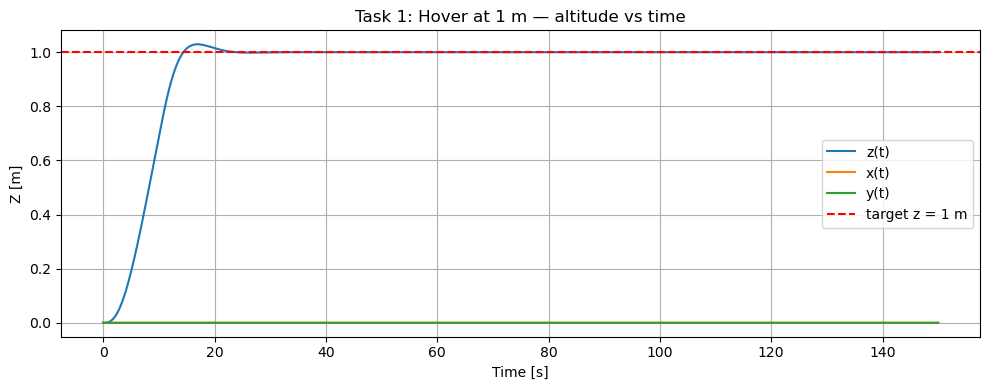

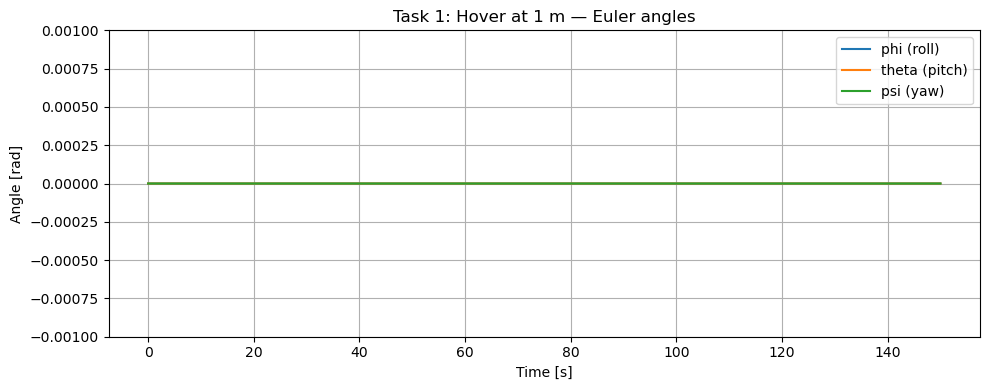

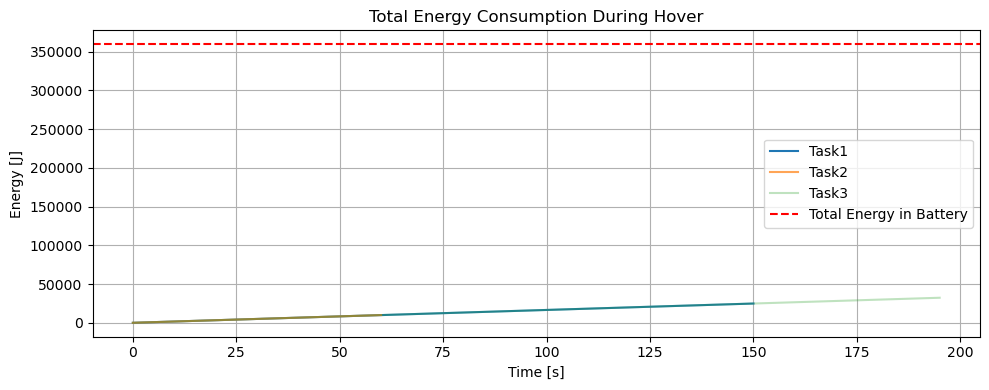

Battery consumed (mAh): 311.2683055052497
Percent of 1300 mAh battery used: 6.917073455672216 %


In [14]:

import numpy as np
from matplotlib.ticker import ScalarFormatter
def desired_trajectory_hover(t):

    T_takeoff = 10.0
    if t < 0.0:
        z_d = 0.0
    elif t < T_takeoff:
        z_d = np.interp(t, [0.0, T_takeoff], [0.0, 1.0])
    else:
        z_d = 1.0

    x_d = 0.0
    y_d = 0.0
    psi_d = 0.0

    pos_d = np.array([x_d, y_d, z_d])
    vel_d = np.zeros(3)
    acc_d = np.zeros(3)

    return pos_d, vel_d, acc_d, psi_d



Kp_pos_hover = np.array([0.4, 0.4, 0.2])
Kd_pos_hover = np.array([0.5, 0.5, 0.6])


Kp_att_hover = np.array([0.8, 0.8, 0.8])   # roll, pitch, yaw
Kd_att_hover = np.array([0.4, 0.4, 0.3])


def control_inputs_hover(t, state):

    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = state

    pos = np.array([x, y, z])
    vel = np.array([vx, vy, vz])
    pos_d, vel_d, acc_d, psi_d = desired_trajectory_hover(t)

    e_pos = pos_d - pos
    e_vel = vel_d - vel


    a_des = acc_d + Kp_pos_hover * e_pos + Kd_pos_hover * e_vel
    ax_des, ay_des, az_des = a_des


    T_des = m * (g + az_des)
    T_des = np.clip(T_des, 0.0, 2.0 * m * g)

    theta_des = ax_des / g
    phi_des   = -ay_des / g


    phi_des   = np.clip(phi_des,   -np.deg2rad(20), np.deg2rad(20))
    theta_des = np.clip(theta_des, -np.deg2rad(20), np.deg2rad(20))

    psi_des = psi_d


    e_phi   = phi_des   - phi
    e_theta = theta_des - theta
    e_psi   = psi_des   - psi

    e_p = -wx
    e_q = -wy
    e_r = -wz

    tau_phi   = Kp_att_hover[0] * e_phi   + Kd_att_hover[0] * e_p
    tau_theta = Kp_att_hover[1] * e_theta + Kd_att_hover[1] * e_q
    tau_psi   = Kp_att_hover[2] * e_psi   + Kd_att_hover[2] * e_r


    tau_phi   = np.clip(tau_phi,   -0.2, 0.2)
    tau_theta = np.clip(tau_theta, -0.2, 0.2)
    tau_psi   = np.clip(tau_psi,   -0.1, 0.1)


    b = np.array([T_des, tau_phi, tau_theta, tau_psi])
    Omega_sq = A_inv @ b
    Omega_sq = np.clip(Omega_sq, 0.0, (2 * m * g / (4 * kf))**2)
    gammas = np.sqrt(Omega_sq)

    return gammas



def quad_dynamics_hover(t, s):

    x, y, z, vx, vy, vz, psi, theta, phi, wx, wy, wz = s

    g1, g2, g3, g4 = control_inputs_hover(t, s)
    T = kf * (g1**2 + g2**2 + g3**2 + g4**2)

    sin_phi   = np.sin(phi)
    cos_phi   = np.cos(phi)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    if abs(cos_theta) < 1e-6:
        cos_theta = 1e-6
    tan_theta = np.tan(theta)

    # Kinematics
    x_dot = vx
    y_dot = vy
    z_dot = vz

    psi_dot   = (wy * np.sin(phi) + wz * np.cos(phi)) / cos_theta
    theta_dot =  wy * cos_phi - wz * sin_phi
    phi_dot   =  wx + wy * sin_phi * tan_theta + wz * cos_phi * tan_theta

    # Translational dynamics
    vx_dot = (T/m)*(cos_phi*cos_psi*sin_theta + sin_phi*sin_psi)
    vy_dot = (T/m)*(cos_phi*sin_psi*sin_theta - cos_psi*sin_phi)
    vz_dot = (T/m)*(cos_phi*cos_theta) - g

    # Torques from rotor speeds
    tau_phi   =  l * kf * (g4**2 - g2**2)
    tau_theta =  l * kf * (g3**2 - g1**2)
    tau_psi   =  kt * (g1**2 - g2**2 + g3**2 - g4**2)

    wx_dot = (tau_phi   - (Izz - Iyy) * wy * wz) / Ixx
    wy_dot = (tau_theta - (Ixx - Izz) * wx * wz) / Iyy
    wz_dot = (tau_psi   - (Iyy - Ixx) * wx * wy) / Izz

    return np.array([
        x_dot, y_dot, z_dot,
        vx_dot, vy_dot, vz_dot,
        psi_dot, theta_dot, phi_dot,
        wx_dot, wy_dot, wz_dot
    ])



T_total_hover = 150.0
dt_hover      = 0.002
N_hover       = int(T_total_hover / dt_hover) + 1

t_hover  = np.linspace(0.0, T_total_hover, N_hover)
states_h = np.zeros((N_hover, 12))

s0 = np.zeros(12)
states_h[0, :] = s0

for k in range(N_hover - 1):
    t = t_hover[k]
    s = states_h[k, :]
    states_h[k+1, :] = rk4_step(quad_dynamics_hover, t, s, dt_hover)


xh  = states_h[:, 0]
yh  = states_h[:, 1]
zh  = states_h[:, 2]
psih   = states_h[:, 6]
thetah = states_h[:, 7]
phih   = states_h[:, 8]
vzh    = states_h[:, 5]


plt.figure(figsize=(10, 4))
plt.plot(t_hover, zh, label='z(t)')
plt.plot(t_hover, xh, label='x(t)')
plt.plot(t_hover, yh, label='y(t)')
plt.axhline(1.0, color='r', linestyle='--', label='target z = 1 m')
plt.xlabel('Time [s]')
plt.ylabel('Z [m]')
plt.title('Task 1: Hover at 1 m — altitude vs time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(t_hover, phih,   label='phi (roll)')
plt.plot(t_hover, thetah, label='theta (pitch)')
plt.plot(t_hover, psih,   label='psi (yaw)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Task 1: Hover at 1 m — Euler angles')
plt.grid(True)
plt.legend()

ymin, ymax = np.min(np.vstack([phih, thetah, psih])), np.max(np.vstack([phih, thetah, psih]))
buffer = 0.001
plt.ylim(ymin - buffer, ymax + buffer)
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.show()



gammas_hist = np.zeros((N_hover, 4))


states_h = np.zeros((N_hover, 12))
states_h[0, :] = s0

for k in range(N_hover - 1):
    t = t_hover[k]
    s = states_h[k, :]


    gam = control_inputs_hover(t, s)
    gammas_hist[k, :] = gam


    states_h[k+1, :] = rk4_step(quad_dynamics_hover, t, s, dt_hover)


gammas_hist[-1, :] = control_inputs_hover(t_hover[-1], states_h[-1, :])



P_mech = np.zeros(N_hover)
P_each = np.zeros((N_hover, 4))

for k in range(N_hover):
    g1, g2, g3, g4 = gammas_hist[k]

    P1 = kt * g1**3
    P2 = kt * g2**3
    P3 = kt * g3**3
    P4 = kt * g4**3

    P_each[k] = np.array([P1, P2, P3, P4])
    P_mech[k] = P1 + P2 + P3 + P4


V_bat = 22.2
eta   = 0.95



P_elec = P_mech / eta

CapTotalE = 4500 / 1000 * 3600 * V_bat # maH -> aH-> as-> J

count1 = np.zeros_like(P_elec)
for i in range(len(P_elec)):
  if i == 0:
    count1[i] = P_elec[i] * dt_hover
  else:
    count1[i] = count1[i-1] + P_elec[i] * dt_hover

plt.figure(figsize=(10, 4))
plt.plot(t_hover, count1 ,alpha = 1,label='Task1')
plt.plot(t_vals, count2,alpha = 0.7,label='Task2')
plt.plot(t_task3, count,alpha = 0.3,label='Task3')
plt.xlabel("Time [s]")
plt.ylabel("Energy [J]")
plt.axhline(CapTotalE, color='r', linestyle='--', label='Total Energy in Battery')
plt.title("Total Energy Consumption During Hover")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

I_bat = P_elec / V_bat


Coulombs = np.trapz(I_bat, t_hover)


mAh_used = Coulombs * 1000 / 3600
print("Battery consumed (mAh):", mAh_used)


battery_size_mAh = 4500
percent_used = 100 * mAh_used / battery_size_mAh
print("Percent of 1300 mAh battery used:", percent_used, "%")

